#  Setup

In [1]:
from __future__ import print_function, division
import time,os,sys,datetime

import IPython
import IPython.display

#Plotting tools
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
#import seaborn as sns
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.grid'] = False
%matplotlib inline
import numpy
#Computation tools
import pandas as pd
import random
import math
import numpy as np
from six import iteritems
import sklearn
import torch
import torch.nn as nn
import mat73
import scipy.io as sio
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from pickle import dump

from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import torch.nn.functional as F
#Printing out the Versions of libraries 
print('Python Version: {}'.format(sys.version))
print('Torch Version: {}'.format(torch.__version__))
print('Matplotlib Version: {}'.format(mpl.__version__))
print('Numpy Version: {}'.format(np.__version__))
print('sklearn Version: {}'.format(sklearn.__version__))
print('Pandas Version: {}'.format(pd.__version__))
#print('Seaborn Version: {}'.format(sns.__version__))
import warnings
warnings.filterwarnings('ignore')
import joblib
#from sklearn.externals import joblib
import csv

Python Version: 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
Torch Version: 2.1.0
Matplotlib Version: 3.5.3
Numpy Version: 1.24.3
sklearn Version: 1.1.3
Pandas Version: 1.5.3


In [2]:
encoder_length = 15
decoder_length=26
input_length=encoder_length+decoder_length
batch_size = 64
stride_trining=decoder_length-1
stride_testing=decoder_length-1
copyies=1
no_of_epoch = 100

# Data loading 

In [5]:
data_dict = mat73.loadmat(r'C:\Users\user\Downloads\New folder (2)\review\mypapers\IJIT_KTCN\R1\Repos\HIghD_test_data.mat')
#data_x_train = data_dict['train_data']
data_x_test = data_dict['Test_data']

In [5]:
len(data_x_test)

(12484, 1916)

# Actual Trajectory Visualization

(0.0, 600.0)

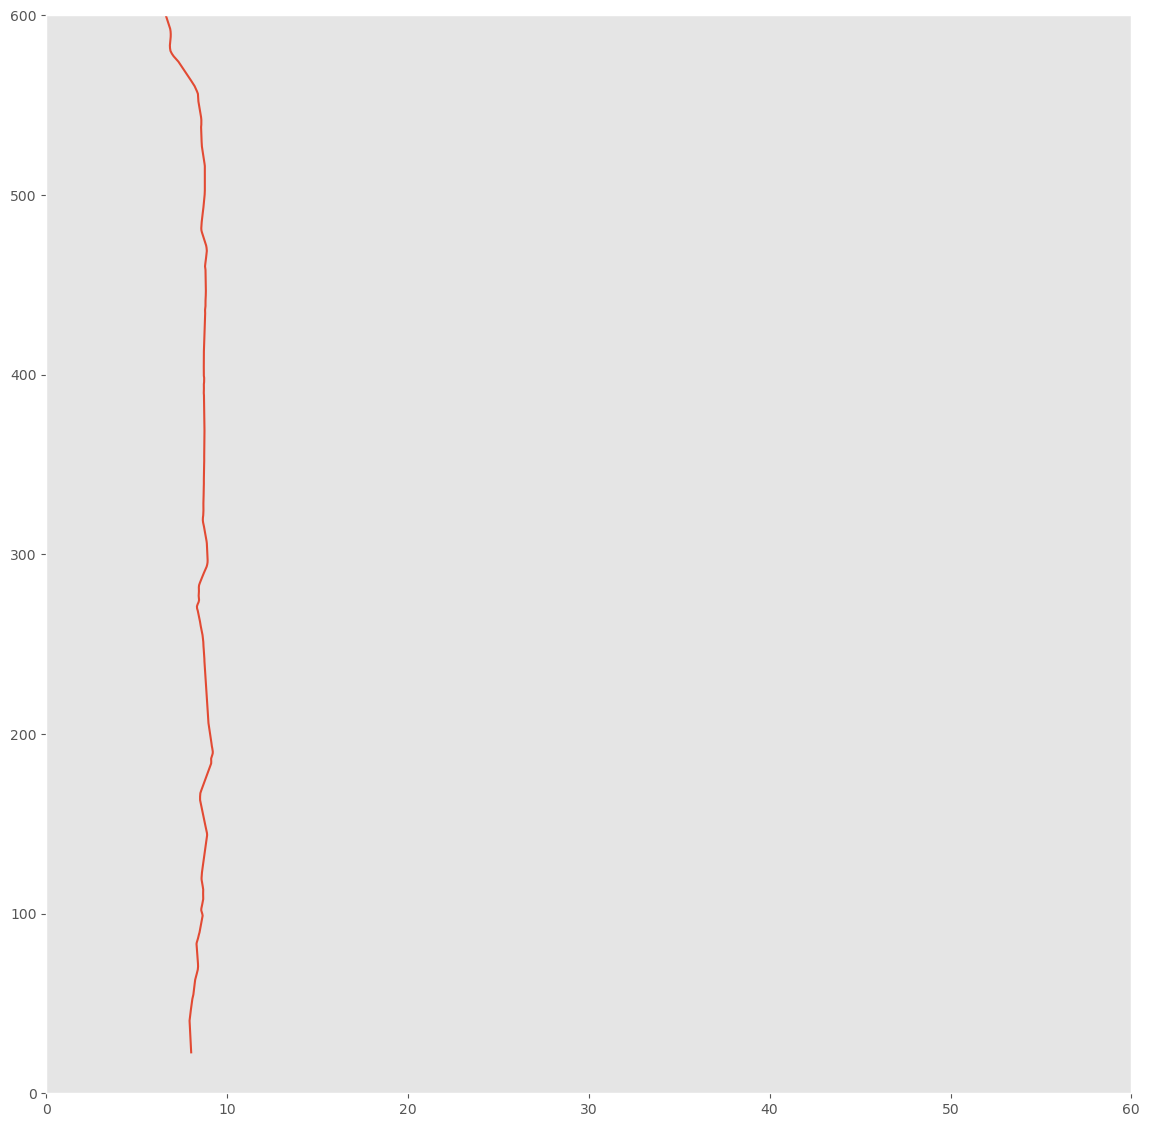

In [8]:
plot_features = data_x_test[1900][0][:,0:2]
plot_features =pd.DataFrame(plot_features)
#plot_features = dataset_fridge['fridge'][155000 : 156500]
#_ = plot_features.plot(subplots=False)
plt.plot(plot_features[0],plot_features[1])
plt.xlim(0, 60)
plt.ylim(0, 600)

## Timeseries making

In [6]:
class timeseries(Dataset):
    def __init__(self,x,y,z):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.z = torch.tensor(z,dtype=torch.float32)        
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx],self.z[idx]
  
    def __len__(self):
        return self.len
    
#train_x_data_tensor_3d=train_x_data_tensor_3d.numpy()
#train_x_data_tensor_3d=train_x_data_tensor_3d.repeat(1,1,copyies)

### Loss functions

In [7]:
class AllLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
        
        self.mse = nn.MSELoss()
        self.mae=nn.L1Loss()
        self.KLD=nn.KLDivLoss(reduction="batchmean")
        
    def rmse(self,a,b):
        return torch.sqrt(self.mse(a,b) + self.eps)  

        
    def forward(self,yhat,y):
        #RMSE_loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        RMSE_loss = self.rmse(yhat,y)
        MSE_Loss= self.mse(yhat,y)
        MAE_Loss=self.mae(yhat,y)
        #KLD_Loss_softmax=self.KLD(F.softmax(yhat),F.softmax(y))
        L1=torch.sqrt(self.mse(yhat[:,:,0],y[:,:,0]) + self.eps)
        L2=torch.sqrt(self.mse(yhat[:,:,1],y[:,:,1]) + self.eps) 
        KLD_Loss=self.KLD(yhat,y)
        return [1.41*RMSE_loss,2*MSE_Loss,2*MAE_Loss,L1,L2,KLD_Loss]

In [8]:
loss_fn1=nn.CrossEntropyLoss()
loss_fn = AllLoss()

### Positional Encoding

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
        #return  self.pos_encoding[:token_embedding.size(0), :]

# Model for reframing data by host vehicle taking 6 sourrounding vehicle and different mixed teacher training


##  with out normalization of data x,y cordinate changed (host vehicle cordinate are frame of reference)and 3D tensor making train and test data

In [11]:
stride_trining_new=5
stride_testing_new=5
avg_l_x=10
avg_l_v=10

In [12]:
# there are many features in the HighD `dataset, here, only positional features have been taken 
training_features=[2,10,18,26,34,42,50,3,11,19,27,35,43,51,4,5,6]

In [13]:
testing_features=  [0,1]
testing_features

[0, 1]

In [14]:
Raw_x_training_data= []      
Raw_y_training_data= []  
Raw_z_training_data= []  
for i in range(0,len(data_x_train)):
    x = torch.tensor(data_x_train[i][0][:,training_features]).clone().detach()
    y = torch.tensor(data_x_train[i][0][:,testing_features]).clone().detach()    
    #x= x[::2].clone().detach()
    #y= y[::2].clone().detach()
    x= x[::5].clone().detach()
    y= y[::5].clone().detach()    
    if len(x)>input_length:
        for j in range(0,len(x)+1-encoder_length-decoder_length-max(avg_l_x,avg_l_v),stride_trining_new):
            a=x[j:j+encoder_length][:].clone().detach()
            b=y[j+encoder_length:j+encoder_length+decoder_length][:].clone().detach()
            d_new= torch.zeros(b.shape[0], 2)
            for k in range (0, b.shape[0]):
                d=[]
                if torch.mean(x[j+encoder_length+k : j+encoder_length+k+avg_l_x,14])<-0.2:
                    if 0.8*x[j+encoder_length+k-1,15]> torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[0,0]
                    elif 1.2*x[j+encoder_length+k-1,15]< torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[0,2]
                    else:
                        d=[0,1]
                            
                elif torch.mean(x[j+encoder_length+k : j+encoder_length+k+avg_l_x,14])>0.2:
                    
                    if 0.8*x[j+encoder_length+k-1,15]> torch.mean(x[j+encoder_length+k : j+encoder_length+k+avg_l_v,15]):
                        d=[2,0]
                    elif 1.2*x[j+encoder_length+k-1,15]< torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[2,2]
                    else:
                        d=[2,1]      
                else:
                    if 0.8*x[j+encoder_length+k-1,15]> torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[1,0]
                    elif 1.2*x[j+encoder_length+k-1,15]< torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[1,2]
                    else:
                        d=[1,1]    
                #print(d)
                d_new[k,:]=torch.tensor(d).clone().detach()
            del d
            c=a[-1,[0,7]].clone().detach()
            
            #a[:,0:2]=a[:,0:2]-c   
            a[:,0:7]=a[:,0:7]-c[0] 
            a[:,7:14]=a[:,7:14]-c[1]  
            b[:,0:2]=b[:,0:2]-c
            
            Raw_x_training_data.append(a.clone().detach())
            Raw_y_training_data.append(b.clone().detach())
            Raw_z_training_data.append(d_new.clone().detach())
            del a,b,c,d_new
        #print(d_new)    
    del x,y
    
Raw_x_training_data = torch.stack(Raw_x_training_data, 0)            
Raw_y_training_data = torch.stack(Raw_y_training_data, 0) 
Raw_z_training_data = torch.stack(Raw_z_training_data, 0) 

In [15]:
Raw_x_testing_data= []      
Raw_y_testing_data= []  
Raw_z_testing_data= []  
for i in range(0,len(data_x_test)):
#for i in range(0,20):
    #x = torch.tensor(data_x_test[i][0][:,0:training_features]).clone().detach()
    #y = torch.tensor(data_x_test[i][0][:,0:testing_features]).clone().detach()
    x = torch.tensor(data_x_test[i][0][:,training_features]).clone().detach()
    y = torch.tensor(data_x_test[i][0][:,testing_features]).clone().detach()
    
    #x= x[::2].clone().detach()
    #y= y[::2].clone().detach()
    x= x[::5].clone().detach()
    y= y[::5].clone().detach()   
    if len(x)>input_length:
        for j in range(0,len(x)+1-encoder_length-decoder_length-max(avg_l_x,avg_l_v),stride_trining_new):
            a=x[j:j+encoder_length][:].clone().detach()
            b=y[j+encoder_length:j+encoder_length+decoder_length][:].clone().detach()
            d_new= torch.zeros(b.shape[0], 2)
            for k in range (0, b.shape[0]):
                d=[]
                if torch.mean(x[j+encoder_length+k : j+encoder_length+k+avg_l_x,14])<-0.2:
                    if 0.8*x[j+encoder_length+k-1,15]> torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[0,0]
                    elif 1.2*x[j+encoder_length+k-1,15]< torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[0,2]
                    else:
                        d=[0,1]
                            
                elif torch.mean(x[j+encoder_length+k : j+encoder_length+k+avg_l_x,14])>0.2:
                    
                    if 0.8*x[j+encoder_length+k-1,15]> torch.mean(x[j+encoder_length+k : j+encoder_length+k+avg_l_v,15]):
                        d=[2,0]
                    elif 1.2*x[j+encoder_length+k-1,15]< torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[2,2]
                    else:
                        d=[2,1]      
                else:
                    if 0.8*x[j+encoder_length+k-1,15]> torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[1,0]
                    elif 1.2*x[j+encoder_length+k-1,15]< torch.mean(x[j+encoder_length+k:j+encoder_length+k+avg_l_v,15]):
                        d=[1,2]
                    else:
                        d=[1,1]    
                #print(d)
                d_new[k,:]=torch.tensor(d).clone().detach()
            del d
            
            c=a[-1,[0,7]].clone().detach()
            #a[:,0:7]=a[:,0:7]-c       
            a[:,0:7]=a[:,0:7]-c[0] 
            a[:,7:14]=a[:,7:14]-c[1]  
            b[:,0:2]=b[:,0:2]-c            
            
            Raw_x_testing_data.append(a.clone().detach())            
            Raw_y_testing_data.append(b.clone().detach())
            Raw_z_testing_data.append(d_new.clone().detach())
            del a,b,c,d_new
    del x,y
    
Raw_x_testing_data = torch.stack(Raw_x_testing_data, 0)            
Raw_y_testing_data = torch.stack(Raw_y_testing_data, 0)
Raw_z_testing_data = torch.stack(Raw_z_testing_data, 0)

In [ ]:
#Raw_x_training_data.shape,Raw_y_training_data.shape,Raw_z_training_data.shape

In [ ]:
#Raw_x_testing_data.shape,Raw_y_testing_data.shape,Raw_z_testing_data.shape

In [18]:
del data_dict,data_x_train ,data_x_test 

##   training and testing  

## Teacher forcing inside sequence

In [19]:
def train_loop_new(epoch,model, opt,loss_fn1,loss_fn,dataloader,teacher_forcing_ratio):
    model.train()
    total_loss=0.
    cur_loss=0.
    cur_loss1=0.
    cur_loss2=0.
    cur_loss3=0.
    for batch,data in enumerate(dataloader):      
        current_lr = scheduler.get_lr()[0]
        X=data[0].clone().detach()
        Y=data[1].clone().detach()
        Z=data[2].clone().detach()
        #print(X.shape,Y.shape,Z.shape)
        Encoder_input=X.clone().detach().to(device) 
        Decoder_input=Y[:,:-1,:].clone().detach().to(device) 
        Decoder_output=Y[:,1:,:].clone().detach().to(device) 
        Encoder_input=torch.tensor(Encoder_input, dtype=torch.float32).to(device)   
        Encoder_output=Z[:,:,:].clone().detach().to(device)
        Encoder_output = torch.tensor(Encoder_output,dtype=torch.long)
        
        #if random.random() < teacher_forcing_ratio:   
        if teacher_forcing_ratio==1.0:
            sequence_length = Decoder_input.shape[1]
            tgt_mask = model.get_tgt_mask(sequence_length).to(device) 
            Decoder_input=Y[:,:-1,:].clone().detach().to(device) 
            #Decoder_input=torch.cat((Decoder_input,Z[:,:-1,:].clone().detach().to(device) ), dim=2)
            Decoder_input=torch.tensor(Decoder_input, dtype=torch.float32).to(device)
            tgt_mask=torch.tensor(tgt_mask, dtype=torch.float32).to(device)  
            #opt.zero_grad()  
        
            a1,a2,pred = model(Encoder_input,Decoder_input, tgt_mask)

        
            
            
            
            del sequence_length,tgt_mask,Decoder_input
        else:
            del Decoder_input
            opt.zero_grad()
            SOS_token = Y[:,0,:].clone().detach().to(device) 
            #SOS_token2 = Z[:,0,:].clone().detach().to(device) 
            Decoder_input = SOS_token.unsqueeze(1).to(device)  
            #Decoder_input=torch.cat((Decoder_input,SOS_token2.unsqueeze(1).to(device)), dim=2)
            max_length=Decoder_output.shape[1]
            #loss_real = torch.empty(size=(max_length, 6))            
            #print(batch,'gello')
            sequence_length = Decoder_input.shape[1]
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)  
            Decoder_input=torch.tensor(Decoder_input, dtype=torch.float32).to(device)
            tgt_mask=torch.tensor(tgt_mask, dtype=torch.float32).to(device)
            a1,a2,pred1 = model(Encoder_input,Decoder_input, tgt_mask)
            
            ##loss3 = loss_fn.rmse(pred1, Decoder_output[:,0:pred1.shape[1],:])
            
                     
             
            Encoder_output_for_loss=Encoder_output[0:a1.shape[0],0,:] 
            #dtype=torch.long
            #print(a1.shape,a2.shape,Encoder_output[:,0].shape)
            ##loss1 = loss_fn1(a1,Encoder_output_for_loss[:,0])
            ##loss2 = loss_fn1(a2,Encoder_output_for_loss[:,1])
            #print(loss1.item(),loss2.item(),loss3.item())
            ##loss=loss1+loss2+loss3
                                   
            ##loss.backward()
            ##torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            ##opt.step()   
            ##opt.zero_grad() 
            #print(pred1.shape,pred1.shape[1])
            del sequence_length,tgt_mask#,Decoder_input#,loss

            for i in range(1,max_length-1):
                #print(i)
                SOS_token = Y[:,0,:].clone().detach().to(device)
                
                if random.random() < teacher_forcing_ratio:   
                    Decoder_input = torch.cat(  (Decoder_input, Y[:,i,:].unsqueeze(1).to(device) ), dim=1)
                else:
                    Decoder_input = torch.cat(   (Decoder_input, pred1[:,-1,:].unsqueeze(1)), dim=1)
                
                
                #Decoder_input = torch.cat((Decoder_input,Z[:,0:i+1,:].clone().detach().to(device)), dim=2)
                sequence_length = Decoder_input.shape[1]
                tgt_mask = model.get_tgt_mask(sequence_length).to(device)  
                Decoder_input=torch.tensor(Decoder_input, dtype=torch.float32).to(device)
                tgt_mask=torch.tensor(tgt_mask, dtype=torch.float32).to(device)
                #print(Encoder_input.shape,Decoder_input.shape, tgt_mask.shape)
                a1,a2,pred1 = model(Encoder_input,Decoder_input, tgt_mask) 
                
                ##loss3 = loss_fn.rmse(pred1, Decoder_output[:,0:pred1.shape[1],:])
            
                Encoder_output_for_loss=Encoder_output[0:a1.shape[0],0,:]          
  
                opt.zero_grad() 
            
            
                del sequence_length,tgt_mask,a1,a2,Encoder_output_for_loss#,loss,loss1,loss2,loss3
            
            
            if random.random() < teacher_forcing_ratio:   
                Decoder_input = torch.cat(  (Decoder_input, Y[:,max_length-1,:].unsqueeze(1).to(device) ), dim=1)
            else:
                Decoder_input = torch.cat(   (Decoder_input, pred1[:,-1,:].unsqueeze(1)), dim=1)
                     
            
            
            
           ## Decoder_input = torch.cat((SOS_token.unsqueeze(1), pred1), dim=1)    
            #Decoder_input = torch.cat((Decoder_input,Z[:,0:-1,:].clone().detach().to(device)), dim=2)
                
            sequence_length = Decoder_input.shape[1]
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)  
            Decoder_input=torch.tensor(Decoder_input, dtype=torch.float32).to(device)
            tgt_mask=torch.tensor(tgt_mask, dtype=torch.float32).to(device)        
               
            a1,a2,pred = model(Encoder_input,Decoder_input, tgt_mask)
            #print(Encoder_input.shape,Decoder_input.shape)
            del SOS_token,sequence_length,tgt_mask,Decoder_input   
        #print(pred.shape, Decoder_output.shape)    
        loss3 = loss_fn.rmse(pred, Decoder_output[:,0:pred.shape[1],:])
        
        Encoder_output_for_loss=Encoder_output[0:a1.shape[0],0,:]          
        #Encoder_output = torch.tensor(Encoder_output,dtype=torch.long) 
        dtype=torch.long
        #print(a1.shape,a2.shape,Encoder_output[:,0].shape)
        loss1 = loss_fn1(a1,Encoder_output_for_loss[:,0])
        loss2 = loss_fn1(a2,Encoder_output_for_loss[:,1])
        #print(loss1.item(),loss2.item(),loss3.item())
        loss=loss1+loss2+loss3
        
        
        
        
        #print(loss.shape)
        #opt.zero_grad()
        loss.backward()
        #loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        opt.step()   
        opt.zero_grad()
        cur_loss += loss.detach().item()
        cur_loss1 += loss1.detach().item()
        cur_loss2 += loss2.detach().item()
        cur_loss3 += loss3.detach().item()
        
        total_loss += loss.detach().item()
        
        
        if batch % 500 == 0 and batch > 0:
            print('tr','|epoch {:3d}|'.format(epoch+1),
                  '|lr {:02.6f}|'.format(scheduler.get_lr()[0]),
                  '|{:5d}/{:5d} batches|'.format(batch,len(dataloader)),
                  'loss {:8.6f}|'.format(loss),
                  'loss per 500 batch {:8.3f}| {:8.3f} |{:8.3f}|{:8.3f}|'.format(cur_loss,cur_loss1,cur_loss2,cur_loss3))        
            cur_loss = 0.
            cur_loss1 = 0.
            cur_loss2 = 0.
            cur_loss3 = 0.
        del pred,loss,X,Y,Encoder_input,Decoder_output,loss1,loss2,loss3,a1,a2,Encoder_output_for_loss
                
    scheduler.step()   
    return total_loss / len(dataloader)


In [20]:
def final_validation_loop(model,loss_fn1, loss_fn,dataloader,max_length):
    #model.eval()
    
    ##loss_real_list=[]
    loss_avg_real= torch.zeros(max_length, 8)
    #print(loss_avg_real)
    with torch.no_grad():
        for batch,data in enumerate(dataloader):     
            #print(batch)
            X=data[0].clone().detach()
            Y=data[1].clone().detach()
            Z=data[2].clone().detach()
            #print(X.shape,Y.shape,Z.shape)
            Encoder_input=X.clone().detach().to(device) 
            #Decoder_input=Y[:,:-1,:].clone().detach().to(device) 
            Decoder_output=Y[:,1:,:].clone().detach().to(device) 
            Encoder_input=torch.tensor(Encoder_input, dtype=torch.float32).to(device)   
            Encoder_output=Z[:,:,:].clone().detach().to(device)
            Encoder_output = torch.tensor(Encoder_output,dtype=torch.long)
        
            SOS_token = Y[:,0,:].clone().detach().to(device) 
            Decoder_input = SOS_token.unsqueeze(1).to(device)  
            max_length=Decoder_output.shape[1]
            loss_real = torch.zeros(max_length, 8)
            
            sequence_length = Decoder_input.shape[1]
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)  
            Decoder_input=torch.tensor(Decoder_input, dtype=torch.float32).to(device)
            tgt_mask=torch.tensor(tgt_mask, dtype=torch.float32).to(device)
            
            a1,a2,pred1 = model(Encoder_input,Decoder_input, tgt_mask)
            
            loss3 = loss_fn.rmse(pred1, Decoder_output[:,0:pred1.shape[1],:])
            Encoder_output_for_loss=Encoder_output[0:a1.shape[0],0,:] 
            loss1 = loss_fn1(a1,Encoder_output_for_loss[:,0])
            loss2 = loss_fn1(a2,Encoder_output_for_loss[:,1])
            
            loss = loss_fn(pred1, Decoder_output[:,0:pred1.shape[1],:])  
                
            loss = torch.Tensor(loss) 
            #print(loss.shape[1])
            loss_real[0,0:6] = loss.clone().detach()       

            del sequence_length,tgt_mask,Decoder_input,loss,loss1,loss2,loss3,a1,a2,Encoder_output_for_loss    
            #print(batch,'gello')
            for i in range(1,max_length):
                Decoder_input = torch.cat((SOS_token.unsqueeze(1), pred1), dim=1)
                sequence_length = Decoder_input.shape[1]
                tgt_mask = model.get_tgt_mask(sequence_length).to(device)  
                
                Decoder_input=torch.tensor(Decoder_input, dtype=torch.float32).to(device)
                tgt_mask=torch.tensor(tgt_mask, dtype=torch.float32).to(device)
                
                a1,a2,pred1= model(Encoder_input,Decoder_input, tgt_mask)      
                            
                loss3 = loss_fn.rmse(pred1, Decoder_output[:,0:pred1.shape[1],:])
                Encoder_output_for_loss=Encoder_output[0:a1.shape[0],0,:] 
                loss1 = loss_fn1(a1,Encoder_output_for_loss[:,0])
                loss2 = loss_fn1(a2,Encoder_output_for_loss[:,1])
            
                loss = loss_fn(pred1, Decoder_output[:,0:pred1.shape[1],:])  
                
                loss = torch.Tensor(loss) 
                loss_real[i,0:6] = loss.clone().detach()

                #loss_real[i] = loss.clone().detach()     
                #print(loss_real.shape,loss.shape)
                #print('hello')
                #print(loss_real[i],loss,loss_real)
                #print('sello')
                del Decoder_input,loss,loss1,loss2,loss3,a1,a2,Encoder_output_for_loss                       

                
            ##loss_real_list+= [loss_real.clone().detach()]
            loss_avg_real+= loss_real.clone().detach()
            
            #print(loss_real.shape,loss_avg_real.shape,len(loss_real_list))
            del loss_real,pred1   
            #print(loss_avg_real)
            #print('tello')
    return loss_avg_real/ len(dataloader)#,loss_real_list





In [18]:
num_of_src_features = Raw_x_testing_data.shape[2]
num_of_tgt_features = Raw_y_testing_data.shape[2]
num_of_tgt_features2= Raw_z_testing_data.shape[2]
#del all_dataloader,val_dataloader

t_dataset = timeseries(Raw_x_training_data.repeat(1,1,copyies).numpy(),Raw_y_training_datan.numpy(),Raw_z_training_datan.numpy())
v_dataset = timeseries(Raw_x_testing_data.repeat(1,1,copyies).numpy(),Raw_y_testing_data.numpy(),Raw_z_testing_data.numpy())

train_dataloader = DataLoader(t_dataset,shuffle=True,batch_size=batch_size)   
val_dataloader = DataLoader(v_dataset,shuffle=False,batch_size=batch_size) 

#del Raw_x_training_data,Raw_y_training_data,Raw_z_training_data,Z_train,t_dataset
#del Raw_x_testing_data,Raw_y_testing_data,Raw_z_testing_data,Z_test,v_dataset


In [41]:
max_length=Raw_y_testing_data.shape[1] -1
max_length

25

In [24]:
del t_dataset,v_dataset

In [25]:
del  Raw_x_training_data,Raw_y_training_data,Raw_z_training_data

In [26]:
del Raw_x_testing_data, Raw_y_testing_data, Raw_z_testing_data

## Model HSTA-KCTN-TF(-BP)

In [21]:
class Kerv1d(nn.Conv1d):
    r"""Applies a 1D kervolution over an input signal composed of several input
        planes.
        Args:
            in_channels (int): Number of channels in the input image
            out_channels (int): Number of channels produced by the convolution
            kernel_size (int or tuple): Size of the convolving kernel
            stride (int or tuple, optional): Stride of the convolution. Default: 1
            padding (int or tuple, optional): Zero-padding added to both sides of
                the input. Default: 0
            padding_mode (string, optional). Accepted values `zeros` and `circular` Default: `zeros`
            dilation (int or tuple, optional): Spacing between kernel
                elements. Default: 1
            groups (int, optional): Number of blocked connections from input
                channels to output channels. Default: 1
            bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
            kernel_type (str), Default: 'linear'
            learnable_kernel (bool): Learnable kernel parameters.  Default: False 
            balance=1, power=3, gamma=1
        Shape:
            - Input: :math:`(N, C_{in}, L_{in})`
            - Output: :math:`(N, C_{out}, L_{out})` where
            .. math::
                L_{out} = \left\lfloor\frac{L_{in} + 2 \times \text{padding} - \text{dilation}
                            \times (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1\right\rfloor
        Examples::
            >>> m = Kerv1d(16, 33, 3, kernel_type='polynomial', learnable_kernel=True)
            >>> input = torch.randn(20, 16, 50)
            >>> output = m(input)
        .. _kervolution:
            https://arxiv.org/pdf/1904.03955.pdf
        """

    def __init__(self, in_channels, out_channels, kernel_size, 
            stride=1, padding=0, dilation=2, groups=1, bias=True, padding_mode='zeros',
            kernel_type='linear', learnable_kernel=False, balance=1, power=3, gamma=1):

        super(Kerv1d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode)
        self.kernel_type, self.learnable_kernel = kernel_type, learnable_kernel
        self.balance, self.power, self.gamma = balance, power, gamma
        self.unfold = nn.Unfold((kernel_size,1), (dilation,1), (padding, 0), (stride,1))

        # parameter for kernels
        if learnable_kernel == True:
            self.balance = nn.Parameter(torch.FloatTensor([balance] * out_channels)).view(-1, 1).to(device)
            self.gamma   = nn.Parameter(torch.FloatTensor([gamma]   * out_channels)).view(-1, 1).to(device)


    def forward(self, input):
        input = self.unfold(input.unsqueeze(-1)).unsqueeze(1)
        weight  = self.weight.view(self.out_channels, -1, 1)

        if self.kernel_type == 'linear':
            output = (input * weight).sum(dim=2)

        elif self.kernel_type == 'manhattan':
            output = -((input - weight).abs().sum(dim=2))

        elif self.kernel_type == 'euclidean':
            output = -(((input - weight)**2).sum(dim=2))

        elif self.kernel_type == 'polynomial':
            output = ((input * weight).sum(dim=2) + self.balance)**self.power

        elif self.kernel_type == 'gaussian':
            output = (-self.gamma*((input - weight)**2).sum(dim=2)).exp() + 0

        else:
            raise NotImplementedError(self.kernel_type+' Kerv1d not implemented')

        if self.bias is not None:
            output += self.bias.view(self.out_channels, -1)

        return output


    def cuda(self, device=None):
        if self.learnable_kernel == True:
            self.balance = self.balance.cuda(device)
            self.gamma = self.gamma.cuda(device)
        return self._apply(lambda t: t.cuda(device))

## KTCN based encoder 

In [22]:
class KTCN_encoder(nn.Module):

    def __init__(self, dim_model, num_of_src_features):
        
        super(KTCN_encoder, self).__init__()
        
        #self.dim_model = dim_model
        self.num_of_src_features = num_of_src_features
        self.num_of_tgt_features = num_of_tgt_features

        self.GeLU = nn.GELU()    
            
        layer_1_dilation_size = 1
        layer_1_kernel_size = 2
        #self.layer_1_dilation_size = layer_1_dilation_size
        #self.layer_1_kernel_size = layer_1_kernel_size
        
        self.layer_1_num_zero_pad = layer_1_dilation_size*(layer_1_kernel_size-1)
        self.temp_conv_layer_1 = nn.Sequential(
                        nn.ZeroPad2d((self.layer_1_num_zero_pad, 0, 0, 0)),
                        Kerv1d(in_channels = num_of_src_features,
                               out_channels = num_of_src_features,
                               kernel_size = layer_1_kernel_size,
                               stride = 1,
                               padding = 0,
                               dilation = layer_1_dilation_size,
                               kernel_type = 'gaussian', 
                               learnable_kernel = True).to(device),
                        nn.GELU()
        )  
        
        layer_2_dilation_size = 2
        layer_2_kernel_size = 2
        self.layer_2_num_zero_pad = layer_2_dilation_size*(layer_2_kernel_size-1)
        self.temp_conv_layer_2 = nn.Sequential(
                        nn.ZeroPad2d((self.layer_2_num_zero_pad, 0, 0, 0)),
                        Kerv1d(in_channels = 2*num_of_src_features,
                               out_channels = 2*num_of_src_features,
                               kernel_size = layer_2_kernel_size,
                               stride = 1,
                               padding = 0,
                               dilation = layer_2_dilation_size,kernel_type = 'gaussian', 
                               learnable_kernel = True).to(device),
                        nn.GELU()
        )         
        
        layer_3_dilation_size = 4
        layer_3_kernel_size = 2
        self.layer_3_num_zero_pad = layer_3_dilation_size*(layer_3_kernel_size-1)
        self.temp_conv_layer_3 = nn.Sequential(
                        nn.ZeroPad2d((self.layer_3_num_zero_pad, 0, 0, 0)),
                        Kerv1d(in_channels = 4*num_of_src_features,
                               out_channels = 4*num_of_src_features,
                               kernel_size = layer_3_kernel_size,
                               stride = 1,
                               padding = 0,
                               dilation = layer_3_dilation_size,kernel_type = 'gaussian', 
                               learnable_kernel = True).to(device),
                        nn.GELU()
                        )       
        layer_4_dilation_size = 8
        layer_4_kernel_size = 2
        self.layer_4_num_zero_pad = layer_4_dilation_size*(layer_4_kernel_size-1)
        self.temp_conv_layer_4 = nn.Sequential(
                        nn.ZeroPad2d((self.layer_4_num_zero_pad, 0, 0, 0)),
                        Kerv1d(in_channels = 8*num_of_src_features,
                               out_channels = 8*num_of_src_features,
                               kernel_size = layer_4_kernel_size,
                               stride = 1,
                               padding = 0,
                               dilation = layer_4_dilation_size,kernel_type = 'gaussian', 
                               learnable_kernel = True).to(device),
                        nn.GELU()            
                        )    
    

        
        self.fully_connected = nn.Sequential(
                        nn.Linear(16*num_of_src_features, dim_model)
                        )   
        
    def forward(self, src): 
        
        input_seq = src.permute(0,2,1) # out_size: batch, features, seq_len    
        #print(input_seq.shape)
        output_1 = self.temp_conv_layer_1(input_seq)  # out_size: batch, feature, seq_len
           
        input_seq = input_seq + output_1 # residual connection
        input_seq = torch.cat((input_seq, output_1), dim=1) 
        #print(input_seq.shape,output_1.shape)
        
        output_2 = self.temp_conv_layer_2(input_seq)
        
        input_seq = input_seq + output_2 # residual connection
        input_seq = torch.cat((input_seq, output_2), dim=1)
        #print(input_seq.shape,output_2.shape)
        
        output_3 = self.temp_conv_layer_3(input_seq)
        
        input_seq = input_seq + output_3 # residual connection
        input_seq = torch.cat((input_seq, output_3), dim=1)
        #print(input_seq.shape,output_3.shape)
        
        output_4 = self.temp_conv_layer_4(input_seq)
        
        input_seq = input_seq + output_4 # residual connection
        input_seq = torch.cat((input_seq, output_4), dim=1)
        #print(input_seq.shape,output_4.shape)
        
        #output_5 = self.temp_conv_layer_5(input_seq)
        
        #input_seq = input_seq + output_5 # residual connection
        #input_seq = torch.cat((input_seq, output_5), dim=1)
        #print(input_seq.shape,output_5.shape)
        
        #input_seq = self.GeLU(input_seq)

        output = input_seq.permute(0,2,1) # out_size: batch,  seq_len, feature
        #print(input_seq.shape,output.shape) 
        #print('hello')
        #output = torch.flatten(output, 1)

        output = self.fully_connected(output)
        #print(input_seq.shape,output.shape)
        return output           

## Transformer_KCTNencoders with the TF based decoder

In [23]:
class SCTransformer_encoder_decoder(nn.Module):

    # Constructor
    def __init__(
        self,
        dim_model,
        len_encoder,
        dim_model_O_vehicle,
        dim_model_T_vehicle,
        num_heads,
        num_O_vehicle_heads,
        num_T_vehicle_heads,
        num_encoder_layers,
        num_encoder_layers_o_vehicle,
        num_encoder_layers_T_vehicle,
        num_decoder_layers,
        dropout_p,
        num_of_src_features,
        num_of_tgt_features,
        num_of_src_features_O_vehic=2,
        num_of_src_features_T_vehic=5
    ):
        super().__init__()

        # INFO
        self.model_type = "SCTransformer_encoder_decoder"
        self.dim_model = dim_model
        self.num_of_src_features = num_of_src_features
        self.num_of_tgt_features = num_of_tgt_features
        
        #self.KCTNT = nn.Linear(  num_of_src_features_T_vehic,dim_model_T_vehicle)
        self.KCTNT = KTCN_encoder( dim_model_T_vehicle, num_of_src_features_T_vehic)
        self.KCTN1 = KTCN_encoder( dim_model_O_vehicle, num_of_src_features_O_vehic)
        self.KCTN2 = KTCN_encoder( dim_model_O_vehicle, num_of_src_features_O_vehic)
        self.KCTN3 = KTCN_encoder( dim_model_O_vehicle, num_of_src_features_O_vehic)
        self.KCTN4 = KTCN_encoder( dim_model_O_vehicle, num_of_src_features_O_vehic)
        self.KCTN5 = KTCN_encoder( dim_model_O_vehicle, num_of_src_features_O_vehic)
        self.KCTN6 = KTCN_encoder( dim_model_O_vehicle, num_of_src_features_O_vehic)
        
        #self.multihead_anT = nn.MultiheadAttention(dim_model_T_vehicle, num_T_vehicle_heads,bias=True)
        self.multihead_an1 = nn.MultiheadAttention(dim_model_O_vehicle, num_O_vehicle_heads,bias=True)
        self.multihead_an2 = nn.MultiheadAttention(dim_model_O_vehicle, num_O_vehicle_heads,bias=True)
        self.multihead_an3 = nn.MultiheadAttention(dim_model_O_vehicle, num_O_vehicle_heads,bias=True)
        self.multihead_an4 = nn.MultiheadAttention(dim_model_O_vehicle, num_O_vehicle_heads,bias=True)
        self.multihead_an5 = nn.MultiheadAttention(dim_model_O_vehicle, num_O_vehicle_heads,bias=True)
        self.multihead_an6 = nn.MultiheadAttention(dim_model_O_vehicle, num_O_vehicle_heads,bias=True)
        
       
        
        #self.MHA_encoders_combine = nn.Linear(5+(2*dim_model_T_vehicle)+(6*dim_model_O_vehicle), dim_model)
        #self.Linear1= nn.Linear(dim_model_T_vehicle+(6*dim_model_O_vehicle), dim_model)         
        #self.Linear2= nn.Linear(dim_model_T_vehicle+(6*dim_model_O_vehicle), dim_model)      
        self.Linear1= nn.Linear(6*dim_model_O_vehicle, dim_model)         
        self.Linear2= nn.Linear(6*dim_model_O_vehicle, dim_model)    
        self.Linear3= nn.Linear(dim_model_T_vehicle, dim_model)        
        #self.embedding_encoder = nn.Linear(num_of_src_features, dim_model)

        self.multihead_an = nn.MultiheadAttention(dim_model, num_heads,bias=True)      
        #self.encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads, dropout=dropout_p)    
        #self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)  
        self.Linear4= nn.Linear(2*dim_model, dim_model)  
        

        self.embedding_decoder = nn.Linear(2, dim_model)
        self.embedding_for_pridectedbehavior = nn.Linear(6, dim_model)
        self.embedding = nn.Linear(8, dim_model)
        
        self.decoder1 = nn.Linear(dim_model*len_encoder,30) 
        self.dropoutlayer1=nn.Dropout(p=dropout_p)
        self.decoder11 = nn.Linear(30,3)        
        self.decoder2 = nn.Linear(dim_model*len_encoder,30) 
        self.dropoutlayer2=nn.Dropout(p=dropout_p)
        self.decoder22 = nn.Linear(30,3)  

        
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=dim_model, nhead=num_heads, dropout=dropout_p)    
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)  
        self.decoder3 = nn.Linear(dim_model,num_of_src_features_O_vehic)  
    
    def forward(self, src,tgt,tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None): 
        #print(src.shape,tgt.shape)
        #srcT=self.KCTNT(src[:,:,0:5])          
        src1=self.KCTN1(src[:,:,[1,8]])
        src2=self.KCTN2(src[:,:,[2,9]])
        src3=self.KCTN3(src[:,:,[3,10]])
        src4=self.KCTN4(src[:,:,[4,11]])
        src5=self.KCTN5(src[:,:,[5,12]])
        src6=self.KCTN6(src[:,:,[6,13]])        
        srcT=self.KCTNT(src[:,:,[0,7,14,15,16]])  
        ##attn_outputT, attn_output_weightsT = self.multihead_anT(srcT.permute(1,0,2),srcT.permute(1,0,2),srcT.permute(1,0,2))
        
        attn_output1, attn_output_weights1 = self.multihead_an1(srcT.permute(1,0,2),src1.permute(1,0,2),src1.permute(1,0,2))
        attn_output2, attn_output_weights2 = self.multihead_an2(srcT.permute(1,0,2),src2.permute(1,0,2),src2.permute(1,0,2))
        attn_output3, attn_output_weights3 = self.multihead_an3(srcT.permute(1,0,2),src3.permute(1,0,2),src3.permute(1,0,2))
        attn_output4, attn_output_weights4 = self.multihead_an4(srcT.permute(1,0,2),src4.permute(1,0,2),src4.permute(1,0,2))
        attn_output5, attn_output_weights5 = self.multihead_an5(srcT.permute(1,0,2),src5.permute(1,0,2),src5.permute(1,0,2))
        attn_output6, attn_output_weights6 = self.multihead_an6(srcT.permute(1,0,2),src6.permute(1,0,2),src6.permute(1,0,2))                
        
        #Target_V_data=src[:,:,0:5]
        attn_outputT = srcT.permute(1,0,2)
        #print(attn_outputT.shape)
        #src=torch.cat((Target_V_data,srcT,attn_outputT,attn_output1,attn_output2,attn_output3,attn_output4,attn_output5,attn_output6),dim=2)
        src=torch.cat((attn_output1,attn_output2,attn_output3,attn_output4,attn_output5,attn_output6),dim=2)        
        #src = src.permute(1,0,2)
        #print(src.shape,attn_outputT.shape )
        V,K=self.Linear1(src),self.Linear2(src)
        Q=self.Linear3(attn_outputT)

        #print(Q.shape,V.shape)
        
        attn_output, attn_output_weights= self.multihead_an(Q,K,V)  
    
        attn_output = torch.cat((attn_output,Q),dim=2).permute(1,0,2)
        attn_output=self.Linear4(attn_output)
        # Attention making code     
        #print(attn_output.shape )

                        
        transformer_out1 = attn_output
        
        transformer_out1 = torch.flatten(transformer_out1, 1)
        #print(src.shape,tgt.shape,transformer_out1.shape)
        transformer_out11 = self.decoder1(transformer_out1)        
        transformer_out11=F.relu(self.dropoutlayer1(transformer_out11))
        transformer_out11 = self.decoder11(transformer_out11)
 
        transformer_out12 = self.decoder2(transformer_out1)        
        transformer_out12=F.relu(self.dropoutlayer2(transformer_out12))
        transformer_out12 = self.decoder22(transformer_out12)
        
        decoder_input=torch.cat((transformer_out11,transformer_out12),dim=1)
        
        #print(transformer_out11.shape,transformer_out12.shape,decoder_input.shape)
        decoder_input=decoder_input.unsqueeze(1)
        #print(transformer_out11.shape,transformer_out12.shape,decoder_input.shape)
        decoder_input=decoder_input.expand(decoder_input.shape[0],tgt.shape[1],decoder_input.shape[2])
        #decoder_input=self.embedding_for_pridectedbehavior(decoder_input)
        #print(decoder_input.shape,tgt.shape)
        tgt=torch.cat((decoder_input,tgt),dim=2)
            
        tgt = self.embedding(tgt)  
        tgt = tgt.permute(1,0,2)
        transformer_out=self.transformer_decoder(tgt, attn_output.permute(1,0,2),tgt_mask)
        transformer_out = transformer_out.permute(1,0,2)   
        transformer_out = self.decoder3(transformer_out)

        return transformer_out11,transformer_out12,transformer_out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)       


In [24]:
dim_model = 64
num_heads = 8
num_encoder_layers = 1
num_decoder_layers = 1
dropout_p = 0.2

In [25]:
dim_model_O_vehicle=64
dim_model_T_vehicle=64

num_O_vehicle_heads=8
num_T_vehicle_heads=8

num_encoder_layers_o_vehicle=1
num_encoder_layers_T_vehicle=1


In [26]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
  

In [27]:
device

device(type='cpu')

In [28]:
encoder_length

15

In [29]:
tf_model_2 = SCTransformer_encoder_decoder(dim_model = dim_model,
                                           len_encoder=encoder_length,
                                           dim_model_O_vehicle = dim_model_O_vehicle,
                                           dim_model_T_vehicle = dim_model_T_vehicle,
                                           num_heads = num_heads,
                                           num_O_vehicle_heads=num_O_vehicle_heads,
                                           num_T_vehicle_heads=num_T_vehicle_heads,
                                           num_encoder_layers = num_encoder_layers,
                                           num_encoder_layers_o_vehicle=num_encoder_layers_o_vehicle,
                                           num_encoder_layers_T_vehicle=num_encoder_layers_T_vehicle,
                                           num_decoder_layers = num_decoder_layers,
                                           dropout_p = dropout_p,
                                           num_of_src_features = num_of_src_features,
                                           num_of_tgt_features = num_of_tgt_features,
                                           num_of_src_features_O_vehic=2,
                                           num_of_src_features_T_vehic=5).to(device)


In [32]:
file_name_Best_model2='Best_model_HSTA-KTCN-TF.pt'
file_name_Best_model2_test='HSTA-KTCN-TF_test_loss.csv'


In [38]:
learning_rate=0.00005
learning_rate=learning_rate*0.95
opt = torch.optim.AdamW(tf_model_2.parameters(), lr = learning_rate)
loss_fn = AllLoss()
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5.0, gamma=0.8)
teacher_forcing_ratio=1.0

In [ ]:
# Used for plotting later on    
print("Training and validating model")
for epoch in range(0,100):
    teacher_forcing_ratio=teacher_forcing_ratio-0.02
    print(teacher_forcing_ratio)
    
    a = train_loop_new(epoch,tf_model_2,opt,loss_fn1,loss_fn,train_dataloader,teacher_forcing_ratio = teacher_forcing_ratio)   
    final_validation_loss = final_validation_loop(tf_model_2,loss_fn1, loss_fn,val_dataloader,max_length)
    print(final_validation_loss[-1,0])

torch.save(tf_model_2.state_dict(),file_name_Best_model2) 
#pd.DataFrame(final_validation_loss).to_csv(file_name_Best_model2_test)                 

## testing 

In [ ]:
tf_model_2.load_state_dict(torch.load(file_name_Best_model2))
learning_rate=0.00005
learning_rate=learning_rate*0.95
opt = torch.optim.AdamW(tf_model_2.parameters(), lr = learning_rate)
loss_fn = AllLoss()
scheduler = torch.optim.lr_scheduler.StepLR(opt, 1.0, gamma=0.8)

In [ ]:
final_validation_loss = final_validation_loop(tf_model_2,loss_fn1, loss_fn,val_dataloader,max_length)

In [60]:
pd.DataFrame(final_validation_loss).to_csv(file_name_Best_model2_test)  

In [34]:
file_name_Best_model2_test

'HSTA-KTCN-TF_test_loss.csv'

In [ ]:
RMSE_loss=final_validation_loss[[4::5],0]
RMSE_loss

In [ ]:
MAE_loss=final_validation_loss[[4::5],2]
MAE_loss